<a href="https://colab.research.google.com/github/ronnief1/Polyp-Segmentation/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 42.3 MB/s 
     |████████████████████████████████| 125 kB 68.4 MB/s 
     |████████████████████████████████| 92.6 MB 69 kB/s 
     |████████████████████████████████| 246 kB 55.5 MB/s 
     |████████████████████████████████| 367 kB 62.8 MB/s 
     |████████████████████████████████| 50 kB 3.7 MB/s 
     |████████████████████████████████| 3.2 MB 47.3 MB/s 
     |████████████████████████████████| 1.4 MB 42.6 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29742 sha256=168d55f29cb3b83149b4f2422ae464a4d70da31b5d0e20d7ff69e9f86cb9e479
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417108 sha256=e9f10c8225057104b5965ef1d05959b33ed7

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = './drive/MyDrive/ColabNotebooks/AppliedDeepLearning/Kvasir-SEG/output/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
class Dataset(BaseDataset):
    """Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['polyp', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[np.where(mask < 8)] = 0
        mask[np.where(mask > 8)] = 255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

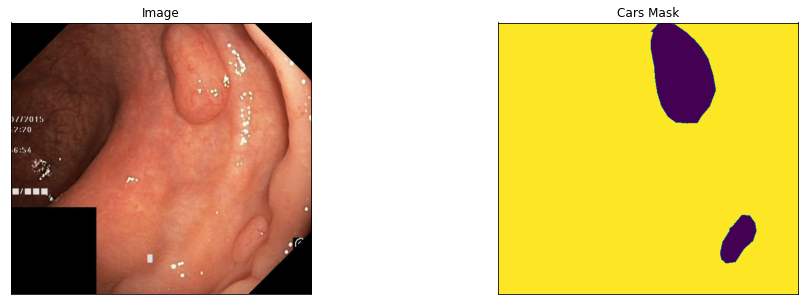

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['polyp'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
        
        albu.Resize(576, 736, always_apply=True, p=1),
        

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #lbu.PadIfNeeded(384, 480)
        albu.Resize(576, 736)
        #albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['polyp', 'background'],
)

# same image with different random transforms
#for i in range(5):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask)

## Create model and train

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
# try different params for UNet++ function
# aux_params=dict(
#     pooling='avg',             # one of 'avg', 'max'
#     dropout=0.5,               # dropout ratio, default is None
#     activation='sigmoid',      # activation function, default is None
#     classes=4,                 # define number of output labels
# )
# model = smp.Unet('resnet34', classes=4, aux_params=aux_params)

In [16]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['polyp', 'background']
ACTIVATION = 'sigmoid'

In [17]:
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



## Training

In [24]:
import torch
import torch.nn as nn
from catalyst.dl.callbacks import EarlyStoppingCallback
from catalyst.dl.experiments import SupervisedRunner
# experiment setup
num_epochs = 10  # change me
logdir = "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

# model, criterion, optimizer
# model = # already defined
criterion = smp.losses.DiceLoss(mode='binary')  #BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

# @TODO: add metrics support 
# (catalyst expects logits, rather than sigmoid outputs)
#metrics = [
#     smp.  metrics.iou_score() 
     #IoUMetric(eps=1.),
     #smp.utils.metrics.FscoreMetric(eps=1.),
#]


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    callbacks=[
        EarlyStoppingCallback(
            patience=3, metric="loss", minimize=True
        )
    ],
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/10 * Epoch (train):   0% 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



0/10 * Epoch (train):   0% 0/200 [01:07<?, ?it/s]
0/10 * Epoch (train): 100% 200/200 [02:44<00:00,  1.31it/s, _fps=130.069, loss=0.592]
0/10 * Epoch (train): 100% 200/200 [02:45<00:00,  1.21it/s, _fps=130.069, loss=0.592]
0/10 * Epoch (valid):   0% 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



0/10 * Epoch (valid): 100% 100/100 [00:41<00:00,  2.42it/s, _fps=60.103, loss=0.433]
[2022-11-08 20:48:36,969] 
0/10 * Epoch 0 (train): _fps=83.9618 | base/batch_time=0.1031 | base/data_time=0.0679 | base/lr=0.0010 | base/model_time=0.0351 | base/momentum=0.9000 | loss=0.5406
0/10 * Epoch 0 (valid): _fps=24.1560 | base/batch_time=0.3639 | base/data_time=0.3321 | base/lr=0.0010 | base/model_time=0.0317 | base/momentum=0.9000 | loss=0.4495
[2022-11-08 20:48:36,969] 
0/10 * Epoch 0 (train): _fps=83.9618 | base/batch_time=0.1031 | base/data_time=0.0679 | base/lr=0.0010 | base/model_time=0.0351 | base/momentum=0.9000 | loss=0.5406
0/10 * Epoch 0 (valid): _fps=24.1560 | base/batch_time=0.3639 | base/data_time=0.3321 | base/lr=0.0010 | base/model_time=0.0317 | base/momentum=0.9000 | loss=0.4495
[2022-11-08 20:48:36,969] 
0/10 * Epoch 0 (train): _fps=83.9618 | base/batch_time=0.1031 | base/data_time=0.0679 | base/lr=0.0010 | base/model_time=0.0351 | base/momentum=0.9000 | loss=0.5406
0/10 * Ep

INFO:metrics:
0/10 * Epoch 0 (train): _fps=83.9618 | base/batch_time=0.1031 | base/data_time=0.0679 | base/lr=0.0010 | base/model_time=0.0351 | base/momentum=0.9000 | loss=0.5406
0/10 * Epoch 0 (valid): _fps=24.1560 | base/batch_time=0.3639 | base/data_time=0.3321 | base/lr=0.0010 | base/model_time=0.0317 | base/momentum=0.9000 | loss=0.4495


1/10 * Epoch (train): 100% 200/200 [02:40<00:00,  1.25it/s, _fps=111.028, loss=0.447]
1/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.41it/s, _fps=46.203, loss=0.436]
[2022-11-08 20:51:42,657] 
1/10 * Epoch 1 (train): _fps=82.7402 | base/batch_time=0.0936 | base/data_time=0.0638 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.5245
1/10 * Epoch 1 (valid): _fps=34.5757 | base/batch_time=0.0343 | base/data_time=0.0161 | base/lr=0.0010 | base/model_time=0.0181 | base/momentum=0.9000 | loss=0.4494
[2022-11-08 20:51:42,657] 
1/10 * Epoch 1 (train): _fps=82.7402 | base/batch_time=0.0936 | base/data_time=0.0638 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.5245
1/10 * Epoch 1 (valid): _fps=34.5757 | base/batch_time=0.0343 | base/data_time=0.0161 | base/lr=0.0010 | base/model_time=0.0181 | base/momentum=0.9000 | loss=0.4494
[2022-11-08 20:51:42,657] 
1/10 * Epoch 1 (train): _fps=82.7402 | base/batch_time=0.0936 | base/data_time=0.0638 | 

INFO:metrics:
1/10 * Epoch 1 (train): _fps=82.7402 | base/batch_time=0.0936 | base/data_time=0.0638 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.5245
1/10 * Epoch 1 (valid): _fps=34.5757 | base/batch_time=0.0343 | base/data_time=0.0161 | base/lr=0.0010 | base/model_time=0.0181 | base/momentum=0.9000 | loss=0.4494


2/10 * Epoch (train): 100% 200/200 [02:44<00:00,  1.22it/s, _fps=80.010, loss=0.554]
2/10 * Epoch (valid): 100% 100/100 [00:09<00:00, 10.90it/s, _fps=51.256, loss=0.432]
[2022-11-08 20:54:40,494] 
2/10 * Epoch 2 (train): _fps=81.3759 | base/batch_time=0.0987 | base/data_time=0.0687 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.5286
2/10 * Epoch 2 (valid): _fps=28.3620 | base/batch_time=0.0489 | base/data_time=0.0208 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4442
[2022-11-08 20:54:40,494] 
2/10 * Epoch 2 (train): _fps=81.3759 | base/batch_time=0.0987 | base/data_time=0.0687 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.5286
2/10 * Epoch 2 (valid): _fps=28.3620 | base/batch_time=0.0489 | base/data_time=0.0208 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4442
[2022-11-08 20:54:40,494] 
2/10 * Epoch 2 (train): _fps=81.3759 | base/batch_time=0.0987 | base/data_time=0.0687 | b

INFO:metrics:
2/10 * Epoch 2 (train): _fps=81.3759 | base/batch_time=0.0987 | base/data_time=0.0687 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.5286
2/10 * Epoch 2 (valid): _fps=28.3620 | base/batch_time=0.0489 | base/data_time=0.0208 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4442


3/10 * Epoch (train): 100% 200/200 [02:43<00:00,  1.22it/s, _fps=121.717, loss=0.491]
3/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.35it/s, _fps=50.892, loss=0.433]
[2022-11-08 20:57:57,150] 
3/10 * Epoch 3 (train): _fps=82.7989 | base/batch_time=0.0896 | base/data_time=0.0603 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.5167
3/10 * Epoch 3 (valid): _fps=33.8477 | base/batch_time=0.0352 | base/data_time=0.0165 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4462
[2022-11-08 20:57:57,150] 
3/10 * Epoch 3 (train): _fps=82.7989 | base/batch_time=0.0896 | base/data_time=0.0603 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.5167
3/10 * Epoch 3 (valid): _fps=33.8477 | base/batch_time=0.0352 | base/data_time=0.0165 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4462
[2022-11-08 20:57:57,150] 
3/10 * Epoch 3 (train): _fps=82.7989 | base/batch_time=0.0896 | base/data_time=0.0603 | 

INFO:metrics:
3/10 * Epoch 3 (train): _fps=82.7989 | base/batch_time=0.0896 | base/data_time=0.0603 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.5167
3/10 * Epoch 3 (valid): _fps=33.8477 | base/batch_time=0.0352 | base/data_time=0.0165 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4462


4/10 * Epoch (train): 100% 200/200 [02:42<00:00,  1.23it/s, _fps=118.793, loss=0.587]
4/10 * Epoch (valid): 100% 100/100 [00:07<00:00, 12.50it/s, _fps=52.330, loss=0.432]
[2022-11-08 21:01:14,811] 
4/10 * Epoch 4 (train): _fps=82.8272 | base/batch_time=0.0892 | base/data_time=0.0607 | base/lr=0.0010 | base/model_time=0.0285 | base/momentum=0.9000 | loss=0.5181
4/10 * Epoch 4 (valid): _fps=35.6771 | base/batch_time=0.0337 | base/data_time=0.0155 | base/lr=0.0010 | base/model_time=0.0182 | base/momentum=0.9000 | loss=0.4421
[2022-11-08 21:01:14,811] 
4/10 * Epoch 4 (train): _fps=82.8272 | base/batch_time=0.0892 | base/data_time=0.0607 | base/lr=0.0010 | base/model_time=0.0285 | base/momentum=0.9000 | loss=0.5181
4/10 * Epoch 4 (valid): _fps=35.6771 | base/batch_time=0.0337 | base/data_time=0.0155 | base/lr=0.0010 | base/model_time=0.0182 | base/momentum=0.9000 | loss=0.4421
[2022-11-08 21:01:14,811] 
4/10 * Epoch 4 (train): _fps=82.8272 | base/batch_time=0.0892 | base/data_time=0.0607 | 

INFO:metrics:
4/10 * Epoch 4 (train): _fps=82.8272 | base/batch_time=0.0892 | base/data_time=0.0607 | base/lr=0.0010 | base/model_time=0.0285 | base/momentum=0.9000 | loss=0.5181
4/10 * Epoch 4 (valid): _fps=35.6771 | base/batch_time=0.0337 | base/data_time=0.0155 | base/lr=0.0010 | base/model_time=0.0182 | base/momentum=0.9000 | loss=0.4421


5/10 * Epoch (train): 100% 200/200 [02:42<00:00,  1.23it/s, _fps=120.911, loss=0.579]
5/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.47it/s, _fps=52.167, loss=0.430]
[2022-11-08 21:04:09,268] 
5/10 * Epoch 5 (train): _fps=82.5024 | base/batch_time=0.0888 | base/data_time=0.0583 | base/lr=0.0010 | base/model_time=0.0305 | base/momentum=0.9000 | loss=0.5147
5/10 * Epoch 5 (valid): _fps=34.5842 | base/batch_time=0.0342 | base/data_time=0.0151 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.4396
[2022-11-08 21:04:09,268] 
5/10 * Epoch 5 (train): _fps=82.5024 | base/batch_time=0.0888 | base/data_time=0.0583 | base/lr=0.0010 | base/model_time=0.0305 | base/momentum=0.9000 | loss=0.5147
5/10 * Epoch 5 (valid): _fps=34.5842 | base/batch_time=0.0342 | base/data_time=0.0151 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.4396
[2022-11-08 21:04:09,268] 
5/10 * Epoch 5 (train): _fps=82.5024 | base/batch_time=0.0888 | base/data_time=0.0583 | 

INFO:metrics:
5/10 * Epoch 5 (train): _fps=82.5024 | base/batch_time=0.0888 | base/data_time=0.0583 | base/lr=0.0010 | base/model_time=0.0305 | base/momentum=0.9000 | loss=0.5147
5/10 * Epoch 5 (valid): _fps=34.5842 | base/batch_time=0.0342 | base/data_time=0.0151 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.4396


6/10 * Epoch (train): 100% 200/200 [02:44<00:00,  1.21it/s, _fps=89.816, loss=0.449]
6/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.04it/s, _fps=45.837, loss=0.425]
[2022-11-08 21:07:29,981] 
6/10 * Epoch 6 (train): _fps=79.5337 | base/batch_time=0.0958 | base/data_time=0.0604 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5161
6/10 * Epoch 6 (valid): _fps=34.6961 | base/batch_time=0.0371 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0195 | base/momentum=0.9000 | loss=0.4357
[2022-11-08 21:07:29,981] 
6/10 * Epoch 6 (train): _fps=79.5337 | base/batch_time=0.0958 | base/data_time=0.0604 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5161
6/10 * Epoch 6 (valid): _fps=34.6961 | base/batch_time=0.0371 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0195 | base/momentum=0.9000 | loss=0.4357
[2022-11-08 21:07:29,981] 
6/10 * Epoch 6 (train): _fps=79.5337 | base/batch_time=0.0958 | base/data_time=0.0604 | b

INFO:metrics:
6/10 * Epoch 6 (train): _fps=79.5337 | base/batch_time=0.0958 | base/data_time=0.0604 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5161
6/10 * Epoch 6 (valid): _fps=34.6961 | base/batch_time=0.0371 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0195 | base/momentum=0.9000 | loss=0.4357


7/10 * Epoch (train): 100% 200/200 [02:44<00:00,  1.21it/s, _fps=84.381, loss=0.494]
7/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.26it/s, _fps=55.588, loss=0.424]
[2022-11-08 21:10:26,906] 
7/10 * Epoch 7 (train): _fps=80.2502 | base/batch_time=0.1019 | base/data_time=0.0620 | base/lr=0.0010 | base/model_time=0.0398 | base/momentum=0.9000 | loss=0.5201
7/10 * Epoch 7 (valid): _fps=34.1565 | base/batch_time=0.0360 | base/data_time=0.0176 | base/lr=0.0010 | base/model_time=0.0184 | base/momentum=0.9000 | loss=0.4352
[2022-11-08 21:10:26,906] 
7/10 * Epoch 7 (train): _fps=80.2502 | base/batch_time=0.1019 | base/data_time=0.0620 | base/lr=0.0010 | base/model_time=0.0398 | base/momentum=0.9000 | loss=0.5201
7/10 * Epoch 7 (valid): _fps=34.1565 | base/batch_time=0.0360 | base/data_time=0.0176 | base/lr=0.0010 | base/model_time=0.0184 | base/momentum=0.9000 | loss=0.4352
[2022-11-08 21:10:26,906] 
7/10 * Epoch 7 (train): _fps=80.2502 | base/batch_time=0.1019 | base/data_time=0.0620 | b

INFO:metrics:
7/10 * Epoch 7 (train): _fps=80.2502 | base/batch_time=0.1019 | base/data_time=0.0620 | base/lr=0.0010 | base/model_time=0.0398 | base/momentum=0.9000 | loss=0.5201
7/10 * Epoch 7 (valid): _fps=34.1565 | base/batch_time=0.0360 | base/data_time=0.0176 | base/lr=0.0010 | base/model_time=0.0184 | base/momentum=0.9000 | loss=0.4352


8/10 * Epoch (train): 100% 200/200 [02:43<00:00,  1.23it/s, _fps=128.575, loss=0.540]
8/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.36it/s, _fps=60.309, loss=0.425]
[2022-11-08 21:13:22,248] 
8/10 * Epoch 8 (train): _fps=79.0508 | base/batch_time=0.0910 | base/data_time=0.0590 | base/lr=0.0010 | base/model_time=0.0320 | base/momentum=0.9000 | loss=0.5105
8/10 * Epoch 8 (valid): _fps=34.7848 | base/batch_time=0.0348 | base/data_time=0.0160 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4346
[2022-11-08 21:13:22,248] 
8/10 * Epoch 8 (train): _fps=79.0508 | base/batch_time=0.0910 | base/data_time=0.0590 | base/lr=0.0010 | base/model_time=0.0320 | base/momentum=0.9000 | loss=0.5105
8/10 * Epoch 8 (valid): _fps=34.7848 | base/batch_time=0.0348 | base/data_time=0.0160 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4346
[2022-11-08 21:13:22,248] 
8/10 * Epoch 8 (train): _fps=79.0508 | base/batch_time=0.0910 | base/data_time=0.0590 | 

INFO:metrics:
8/10 * Epoch 8 (train): _fps=79.0508 | base/batch_time=0.0910 | base/data_time=0.0590 | base/lr=0.0010 | base/model_time=0.0320 | base/momentum=0.9000 | loss=0.5105
8/10 * Epoch 8 (valid): _fps=34.7848 | base/batch_time=0.0348 | base/data_time=0.0160 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4346


9/10 * Epoch (train): 100% 200/200 [02:46<00:00,  1.20it/s, _fps=117.816, loss=0.617]
9/10 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.29it/s, _fps=54.833, loss=0.425]
[2022-11-08 21:16:19,378] 
9/10 * Epoch 9 (train): _fps=78.5461 | base/batch_time=0.1047 | base/data_time=0.0712 | base/lr=0.0010 | base/model_time=0.0334 | base/momentum=0.9000 | loss=0.5124
9/10 * Epoch 9 (valid): _fps=32.9744 | base/batch_time=0.0357 | base/data_time=0.0169 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4353
[2022-11-08 21:16:19,378] 
9/10 * Epoch 9 (train): _fps=78.5461 | base/batch_time=0.1047 | base/data_time=0.0712 | base/lr=0.0010 | base/model_time=0.0334 | base/momentum=0.9000 | loss=0.5124
9/10 * Epoch 9 (valid): _fps=32.9744 | base/batch_time=0.0357 | base/data_time=0.0169 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4353
[2022-11-08 21:16:19,378] 
9/10 * Epoch 9 (train): _fps=78.5461 | base/batch_time=0.1047 | base/data_time=0.0712 | 

INFO:metrics:
9/10 * Epoch 9 (train): _fps=78.5461 | base/batch_time=0.1047 | base/data_time=0.0712 | base/lr=0.0010 | base/model_time=0.0334 | base/momentum=0.9000 | loss=0.5124
9/10 * Epoch 9 (valid): _fps=32.9744 | base/batch_time=0.0357 | base/data_time=0.0169 | base/lr=0.0010 | base/model_time=0.0187 | base/momentum=0.9000 | loss=0.4353


Top best models:
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/logs/segmentation_notebook/checkpoints//train.8.pth	0.4346
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/logs/segmentation_notebook/checkpoints//train.7.pth	0.4352
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/logs/segmentation_notebook/checkpoints//train.9.pth	0.4353


### Visualization

In [25]:
from catalyst.dl.utils import UtilsFactory
# you can use plotly and tensorboard to plot metrics inside jupyter
# by default it only plots loss
# not sure if it correctly works in Colab
UtilsFactory.plot_metrics(logdir=logdir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

## Inference

In [26]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [27]:
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback
loaders = {"infer": test_dataloader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)

=> loading checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/logs/segmentation_notebook/checkpoints/best.pth"
loaded checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/logs/segmentation_notebook/checkpoints/best.pth" (epoch 8)
Top best models:



### Visualization

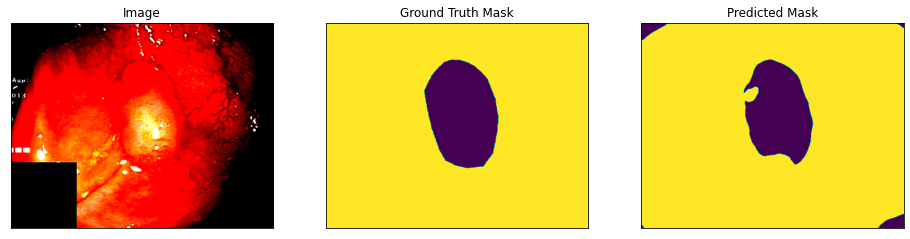

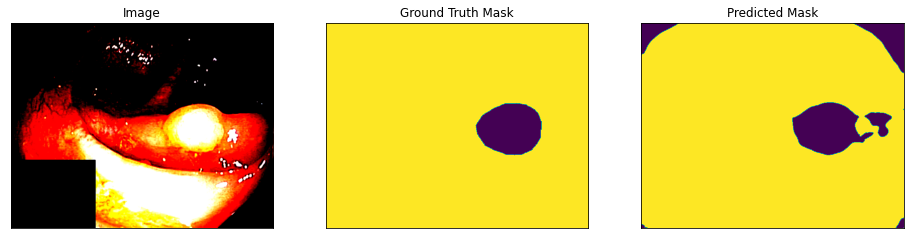

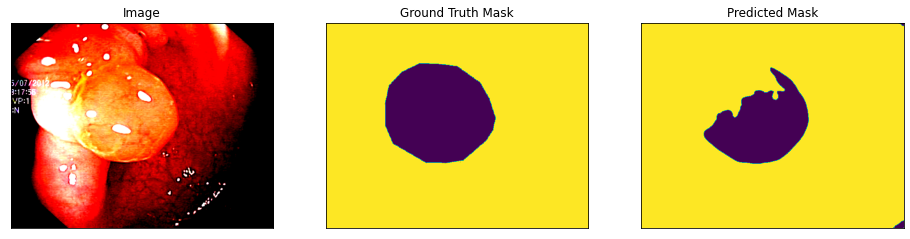

In [28]:
threshold = 0.5
break_at = 2

for i, (input, output) in enumerate(zip(
        test_dataset, runner.callbacks[1].predictions["logits"])):
    image, mask = input
    
    image_vis = image.transpose(1, 2, 0)
    gt_mask = mask[0].astype('uint8')
    pr_mask = (output[0] > threshold).astype('uint8')
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    if i >= break_at:
      break